In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string 
import nltk
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
%matplotlib inline

In [2]:
from chardet.universaldetector import UniversalDetector
import pandas as pd
usock = open('train.csv','rb')
detector = UniversalDetector()
for line in usock.readlines():
    detector.feed(line)
    if detector.done: break
detector.close()
usock.close()
print (detector.result)

{'encoding': 'Windows-1252', 'confidence': 0.7291183236120807, 'language': ''}


In [3]:
train = pd.read_csv('train.csv',encoding='Windows-1252')
test = pd.read_csv('test.csv',encoding='Windows-1252')

In [4]:
test.head()

,ItemID,SentimentText
0,1,is so sad for my APL frie...
1,2,I missed the New Moon trail...
2,3,omg its already 7:30 :O
3,4,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,i think mi bf is cheating on me!!! ...


In [20]:
print(np.unique(train['Sentiment']))

[0 1]


In [5]:
combi=train.append(test,ignore_index=True)

In [6]:
def remove_pattern(input_txt,pattern):
    r=re.findall(pattern,input_txt)
    for i in r:
        input_txt=re.sub(i,'',input_txt)
    return input_txt

In [8]:
#remove twitter handles
combi['tidy_tweet']=np.vectorize(remove_pattern)(combi['SentimentText'],"@[\w]*")

In [9]:
#remove special characters,numbers,punctutations
combi['tidy_tweet']=combi['tidy_tweet'].str.replace("[^a-zA-Z#]"," ")

In [10]:
combi['tidy_tweet']=combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if (len(w)>3)]))

In [24]:
combi.head()

,ItemID,Sentiment,SentimentText,tidy_tweet
0,1,0.0,is so sad for my APL frie...,friend
1,2,0.0,I missed the New Moon trail...,missmoontrailer
2,3,1.0,omg its already 7:30 :O,alreadi
3,4,0.0,.. Omgaga. Im sooo im gunna CRy. I'...,omgagasooogunnabeenthidentistsincsuposjustcrow...
4,5,0.0,i think mi bf is cheating on me!!! ...,thinkcheat


In [12]:
tokenized_tweet = combi['tidy_tweet'].apply(lambda x:x.split())
tokenized_tweet.head()

0                                             [friend]
1                              [missed, Moon, trailer]
2                                            [already]
3    [Omgaga, sooo, gunna, been, this, dentist, sin...
4                                    [think, cheating]
Name: tidy_tweet, dtype: object

In [13]:
from nltk.stem.porter import *
stemmer=PorterStemmer()
tokenized_tweet=tokenized_tweet.apply(lambda x:[stemmer.stem(i) for i in x])
tokenized_tweet.head()

0                                             [friend]
1                                [miss, moon, trailer]
2                                            [alreadi]
3    [omgaga, sooo, gunna, been, thi, dentist, sinc...
4                                       [think, cheat]
Name: tidy_tweet, dtype: object

In [14]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i]=''.join(tokenized_tweet[i])
combi['tidy_tweet']=tokenized_tweet

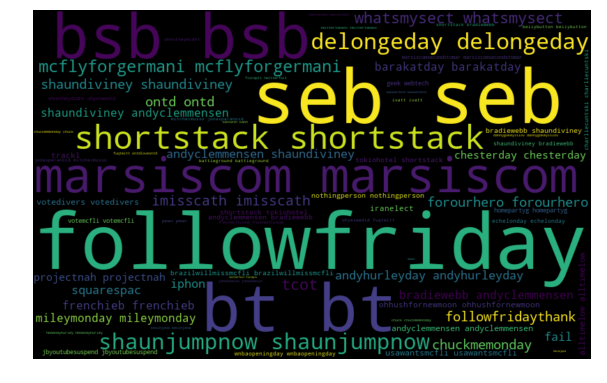

In [17]:
all_words=''.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(all_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

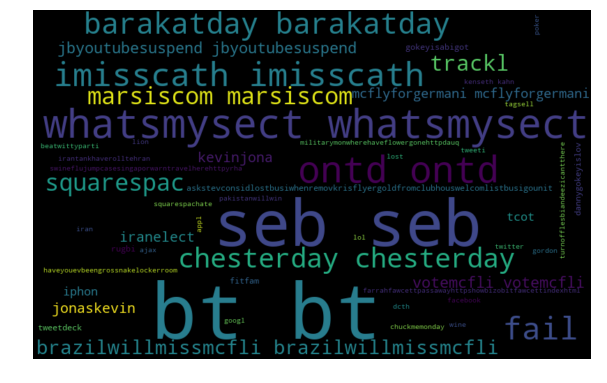

In [18]:
normal_words=''.join([text for text in combi['tidy_tweet'][combi['Sentiment']==0]])
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(normal_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

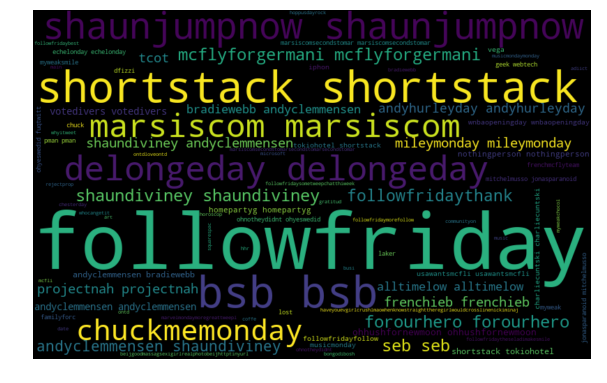

In [21]:
negative_words=''.join([text for text in combi['tidy_tweet'][combi['Sentiment']==1]])
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(negative_words)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

In [22]:
#function to collect hashtags
def hashtag_extract(x):
    hashtags=[]
    #Loop over the words in the tweet
    for i in x:
        ht=re.findall(r"#(\w+)",i)
        hashtags.append(ht)
    return hashtags

In [25]:
# extracting hashtags from positive tweets
HT_regular=hashtag_extract(combi['SentimentText'][combi['Sentiment']==0])

# extracting hashtags from negative tweets
HT_negative=hashtag_extract(combi['SentimentText'][combi['Sentiment']==1])

#unnesting list
HT_regular=sum(HT_regular,[])
HT_negative=sum(HT_negative,[])


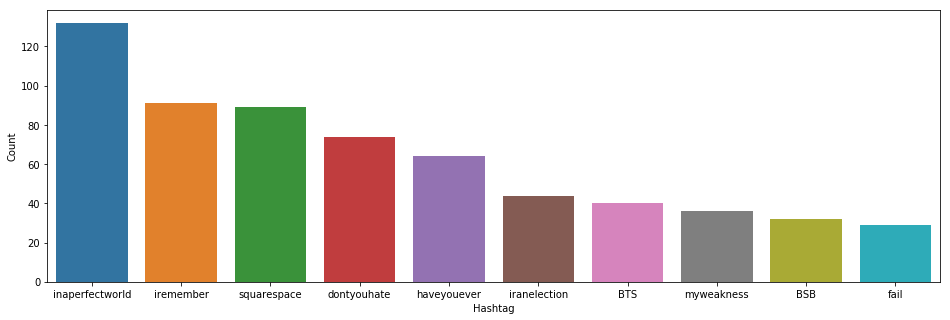

In [26]:
a=nltk.FreqDist(HT_regular)
d=pd.DataFrame({'Hashtag':list(a.keys()),'Count':list(a.values())})

#selecting top 10 most frequent hashtags
d=d.nlargest(columns="Count",n=10)
plt.figure(figsize=(16,5))
ax=sns.barplot(data=d,x="Hashtag",y="Count")
ax.set(ylabel='Count')
plt.show()

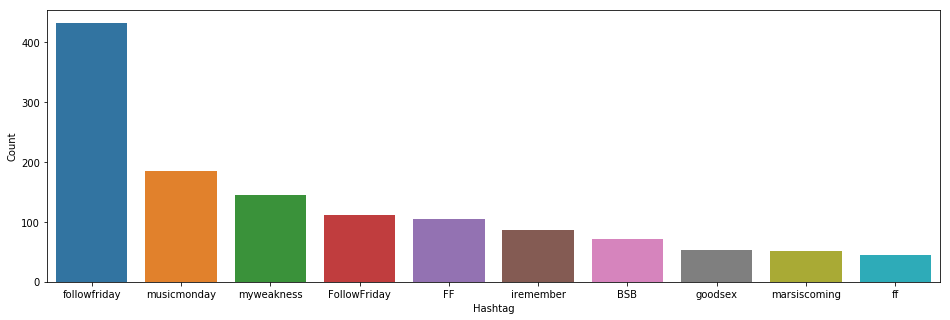

In [27]:
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})

# selecting top 10 most frequent hashtags
e = e.nlargest(columns="Count", n = 10)   
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [71]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90,min_df=2,max_features=1000,stop_words='english')
#bag-of-words feature matrix
bow=bow_vectorizer.fit_transform(combi['tidy_tweet'])

In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(max_df=0.90,min_df=2,max_features=1000,stop_words='english')
#TF-IDF feature matrix
tfidf=tfidf_vectorizer.fit_transform(combi['tidy_tweet'])

In [77]:
print(train.shape)
train__=bow[:99989,:]
test__=bow[99989:,:]

(99989, 3)


In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
xtrain,xvalid,ytrain,yvalid=train_test_split(train__,train['Sentiment'],test_size=0.3)
lreg=LogisticRegression()
lreg.fit(xtrain,ytrain)    #train the model
prediction=lreg.predict_proba(xvalid)     #predicting on the valid
prediction_int=prediction[:,1]>=0.3    #if prediction is greater than or equal to 0.3 than 1 else 0
prediction_int=prediction_int.astype(np.int)

f1_score(yvalid,prediction_int)   #calulating f1 score

0.7216432822672482

In [80]:
test_pred = lreg.predict_proba(test__)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['Sentiment'] = test_pred_int
submission = test[['ItemID','Sentiment']]
submission.to_csv('sub_lreg_bow.csv', index=False) # writing data to a CSV file

In [83]:
tftrain__=tfidf[:99989,:]
tftest__=tfidf[99989:,:]
xtrain_tfidf = tftrain__[ytrain.index]
xvalid_tfidf = tftrain__[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)

prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

f1_score(yvalid, prediction_int)

0.7215967686490203

In [84]:
test_pred = lreg.predict_proba(tftest__)
test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)
test['Sentiment'] = test_pred_int
submission = test[['ItemID','Sentiment']]
submission.to_csv('sub_lreg_tfidf.csv', index=False) # writing data to a CSV file